In [1]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from jax import jit
import optax as ox


In [2]:

import gpjax as gpx
key = jr.PRNGKey(123)

In [11]:
n = 10000
noise = 0.2

x = jr.uniform(key=key, minval=-5.0, maxval=5.0, shape=(n,)).sort().reshape(-1, 1)
f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
signal = f(x)
y = signal + jr.normal(key, shape=signal.shape) * noise

D = gpx.Dataset(X=x, y=y)

xtest = jnp.linspace(-5.5, 5.5, 500).reshape(-1, 1)

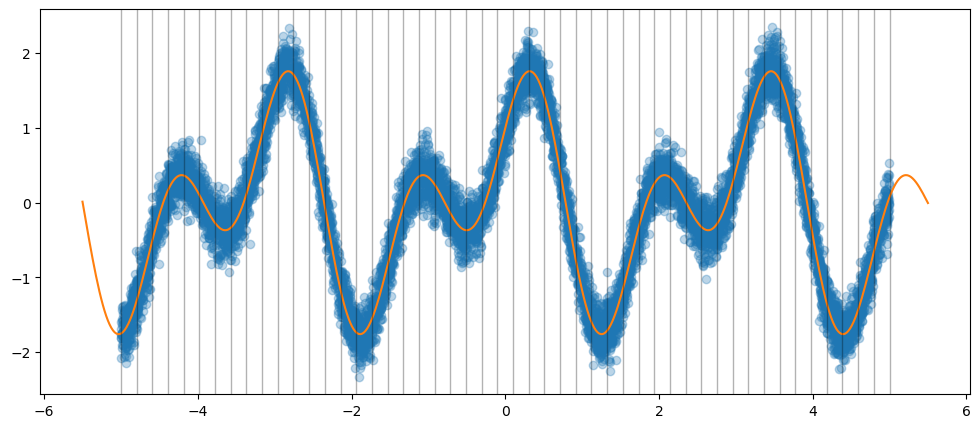

In [12]:
z = jnp.linspace(-5.0, 5.0, 50).reshape(-1, 1)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(x, y, "o", alpha=0.3)
ax.plot(xtest, f(xtest))
[ax.axvline(x=z_i, color="black", alpha=0.3, linewidth=1) for z_i in z]
plt.show()


In [13]:
likelihood = gpx.Gaussian(num_datapoints=n)
prior = gpx.Prior(kernel=gpx.RBF())
p =  prior * likelihood
q = gpx.VariationalGaussian(prior=prior, inducing_inputs=z)

In [14]:
svgp = gpx.StochasticVI(posterior=p, variational_family=q)


In [19]:
params

{'kernel': {'lengthscale': DeviceArray([0.54132485], dtype=float64),
  'variance': DeviceArray([0.54132485], dtype=float64)},
 'likelihood': {'obs_noise': DeviceArray([0.54132485], dtype=float64)},
 'mean_function': {},
 'variational_family': {'inducing_inputs': DeviceArray([[-5.        ],
               [-4.79591837],
               [-4.59183673],
               [-4.3877551 ],
               [-4.18367347],
               [-3.97959184],
               [-3.7755102 ],
               [-3.57142857],
               [-3.36734694],
               [-3.16326531],
               [-2.95918367],
               [-2.75510204],
               [-2.55102041],
               [-2.34693878],
               [-2.14285714],
               [-1.93877551],
               [-1.73469388],
               [-1.53061224],
               [-1.32653061],
               [-1.12244898],
               [-0.91836735],
               [-0.71428571],
               [-0.51020408],
               [-0.30612245],
               [-0.

In [15]:
params, trainables, constrainers, unconstrainers = gpx.initialise(
    svgp, key).unpack()
params = gpx.transform(params, unconstrainers)

loss_fn = jit(svgp.elbo(D, constrainers, negative=True))


/tmp/ipykernel_2751870/2021119448.py:3: DeprecationWarning: `transform` will be deprecated in a future release. As of v0.5.0, please use `constrain` or `unconstrain` instead.
  params = gpx.transform(params, unconstrainers)


In [16]:
params, trainables, constrainers, unconstrainers = gpx.initialise(
    svgp, key).unpack()
params = gpx.transform(params, unconstrainers)

loss_fn = jit(svgp.elbo(D, constrainers, negative=True))


/tmp/ipykernel_2751870/2021119448.py:3: DeprecationWarning: `transform` will be deprecated in a future release. As of v0.5.0, please use `constrain` or `unconstrain` instead.
  params = gpx.transform(params, unconstrainers)


In [17]:
optimiser = ox.adam(learning_rate=0.01)

inference_state = gpx.fit_batches(
    objective=loss_fn,
    params=params,
    trainables=trainables,
    train_data=D,
    optax_optim=optimiser,
    n_iters=4000,
    key=jr.PRNGKey(42),
    batch_size=128
)
learned_params, training_history = inference_state.unpack()
learned_params = gpx.transform(learned_params, constrainers)


  0%|          | 0/4000 [00:00<?, ?it/s]

/tmp/ipykernel_2751870/4088580295.py:14: DeprecationWarning: `transform` will be deprecated in a future release. As of v0.5.0, please use `constrain` or `unconstrain` instead.
  learned_params = gpx.transform(learned_params, constrainers)


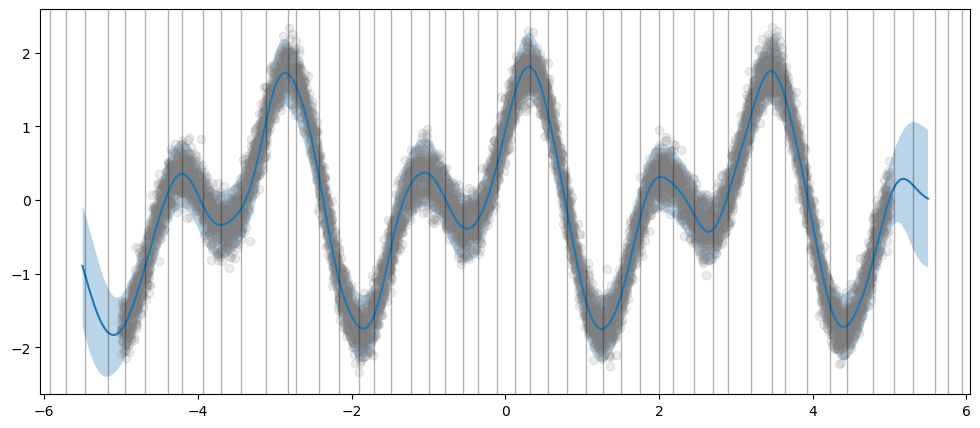

In [18]:
latent_dist = q(learned_params)(xtest)
predictive_dist = likelihood(latent_dist, learned_params)

meanf = predictive_dist.mean()
sigma = predictive_dist.stddev()

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(x, y, "o", alpha=0.15, label="Training Data", color="tab:gray")
ax.plot(xtest, meanf, label="Posterior mean", color="tab:blue")
ax.fill_between(xtest.flatten(), meanf - sigma, meanf + sigma, alpha=0.3)
[
    ax.axvline(x=z_i, color="black", alpha=0.3, linewidth=1)
    for z_i in learned_params["variational_family"]["inducing_inputs"]
]
plt.show()
